In [298]:
from sklearn.datasets import make_circles

n_samples = 1000

X, Y = make_circles(n_samples= n_samples, noise=0.03, random_state=42)

In [299]:
len(X), len(Y)

(1000, 1000)

In [300]:
X[:5], Y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [301]:
import pandas as pd
circles_df = pd.DataFrame({"X1": X[:, 0], "X2" : X[:,1], "Y":Y[:]})
circles_df[:10]

,X1,X2,Y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


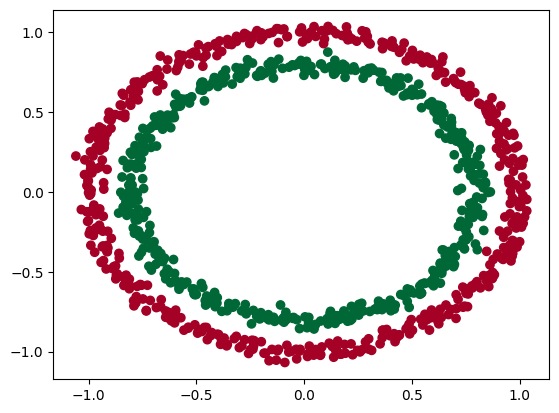

In [302]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0], y = X[:,1], c=Y ,cmap=plt.cm.RdYlGn)

In [303]:
import torch
torch.__version__

'2.2.2+cu121'

In [304]:
# Data to Tensors
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)


In [305]:
X[:3], Y[:3]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733]]),
 tensor([1., 1., 1.]))

In [306]:
type(X), X.shape, X.dim

(torch.Tensor, torch.Size([1000, 2]), <function Tensor.dim>)

In [307]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
type(X_test)

torch.Tensor

In [308]:
len(X_train), len(X_test),len(Y_train), len(Y_test)

(800, 200, 800, 200)

In [309]:
from torch import nn
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available.")

CUDA is available.


In [310]:
class CircleModel0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=2)
        self.layer2 = nn.Linear(in_features=2, out_features=1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

model0  = CircleModel0().to("cuda")

In [311]:
next(model0.parameters()).device

device(type='cuda', index=0)

In [312]:
model0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.3244,  0.0349],
                      [-0.1086,  0.2684]], device='cuda:0')),
             ('layer1.bias', tensor([-0.2530,  0.3772], device='cuda:0')),
             ('layer2.weight', tensor([[-0.1559, -0.1256]], device='cuda:0')),
             ('layer2.bias', tensor([-0.1562], device='cuda:0'))])

In [315]:
X_test = X_test.to("cuda")
untrained_preds = model0(X_test)
print(f"Length of predection: {len(untrained_preds)}, Shape:{untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape:{X_test.shape}")
print(f"\nFirst 10 predections:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{Y_test[:10]}")


Length of predection: 200, Shape:torch.Size([200, 1])
Length of test samples: 200, Shape:torch.Size([200, 2])

First 10 predections:
tensor([[-0.1770],
        [-0.2023],
        [-0.1259],
        [-0.1914],
        [-0.1499],
        [-0.1652],
        [-0.2173],
        [-0.2087],
        [-0.1249],
        [-0.2043]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


                                         <---------------------------------------------------------------------------->                                                                 
For regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how wrong your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

                                         <---------------------------------------------------------------------------->                                                                